# CBDC ABM Simulation

This notebook contains a simulation for a toy economy that consists of a number of households, firms, banks and a central bank. Households are employed at firms, are paid wages for labour, produce output and purchase output. Wages are paid and output is paid for using a combination of deposits at banks and Central Bank Digital Currency.

## Configuring the model

The parameter_values below can be specified for different simulations.

In [29]:
import xml.etree.ElementTree as ET

Below you will find the parameter inputs for this model. Change the parameter values for different configurations of the model.

In [30]:
parameter_values = (('num_sweeps', '244'),
                    ('num_simulations', '1'),
                    ('num_households', '20'),
                    ('num_firms', '8'),
                    ('num_banks', '2'),
                    ('num_ach', '1'),
                    ('num_central_bank', '1'),
                    ('batch', '4'),
                    ('household_directory', 'agents/gen_households/'),
                    ('firm_directory', 'agents/gen_firms/'),
                    ('bank_directory', 'agents/gen_banks/'),
                    ('ach_directory', 'agents/ach/'),
                    ('central_bank_directory', 'agents/central_bank/'),
                    ('measurement_config', 'measurements/test_output.xml')
                   )

To translate this to an xml document, which the framework can read, we first need create an ET element. 

In [31]:
environment = ET.Element('environment', identifier = "CBDC_parameters")

And create parameter elements and give them the values seen below to add to the tree object.

In [32]:
parameters = []
for x in range(len(parameter_values)):
    parameters.append(ET.SubElement(environment, 'parameter'))
    
for idx, p in enumerate(parameters):
    p.set('type', 'static')
    p.set('name', parameter_values[idx][0])
    p.set('value', parameter_values[idx][1])

This object can now be transformed to a string and written to an xml file using the code below. 

In [33]:
xml_params = ET.tostring(environment, encoding="UTF-8")
myfile = open("environments/CBDC_parameters.xml", "w")
xml_params = "<?xml version='1.0' encoding='UTF-8'?>\n" + str(xml_params, encoding = "UTF-8")
myfile.write(xml_params)
myfile.close()

Now, the parameter xml file has been generated and the model can be run. Before, running the model, you need to import a couple of extra modules. These are the Python logging module, the Black Rhino environment class, and the Black Rhino runner class.

In [34]:
import logging
import os
from src.environment import Environment
from src.runner import Runner

Then, before running the model, the logger needs to be initialized.

In [35]:
log_directory = "log/"
identifier = "/CBDC_parameters"
environment_directory = "environments/"
if not os.path.exists('log'):
    os.makedirs('log')
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    filename=log_directory + identifier + ".log", level=logging.INFO)
logging.info('START logging for run: %s',  environment_directory + identifier + ".xml")

Generate banks and households using the generate agents class. First remove any agents still in directories. Then generate agents, the number of households and banks needs to be specified. In the generate banks method, the number of banks is the second argument. In the generate households method, the number of households it the second argument and the number of banks is the thrid argument.

In [36]:
import os
remove = True

bank_dir = os.getcwd()+'/agents/gen_banks/'
house_dir = os.getcwd()+'/agents/gen_households/'
firm_dir = os.getcwd()+'/agents/gen_firms/'
if remove:
    bank_list = [ f for f in os.listdir(bank_dir) if f.startswith("bank") ]
    house_list = [ f for f in os.listdir(house_dir) if f.startswith("house") ]
    firm_list = [ f for f in os.listdir(firm_dir) if f.startswith("firm") ]
for f in bank_list:
    os.remove(os.path.join(bank_dir, f))
for f in house_list:
    os.remove(os.path.join(house_dir, f))
for f in firm_list:
    os.remove(os.path.join(firm_dir, f))

In [37]:
from src.br_generate_agents import Generate_Agents
gen_agents = Generate_Agents()

gen_agents.generate_households(parameter_values[2][1], "./agents/gen_households/")

gen_agents.generate_firms(parameter_values[3][1], "./agents/gen_firms/")

gen_agents.generate_banks(parameter_values[4][1], "./agents/gen_banks/")

First, the environment will be initialized. It contains the model parameters and variables. The environment also contains a list of agents. In the Solow model, the environment contains one bank, one firm, and one household. Finally, it also contains initialized transactions for these agents.

In [38]:
environment = Environment(environment_directory, identifier)


Import GDP data for calibration. Data is average GDP per firm per employee over 4000 (The mean of the labour distribution).

In [39]:
# # importing the module
# import json
  
# # Opening JSON file
# with open('gdp.json') as json_file:
#     gdp_calibrate = json.load(json_file)
# environment.gdp_calibrate = gdp_calibrate

Next up, the runner object is created. As the name suggests, the runner object handles the running of the model. But that is not all, it also initializes the updater.

In [40]:
runner = Runner(environment)

Now you can actually run the model. Since the agent-based model is simulated using Monte Carlo methods. This means that the model will be run multiple times (num_simulations). For every simulation run, the environment and runner will be (re-)initialized. Then, the runner will run the Solow model. During the run, the runner will write data about capital to a csv file specified within the Measurement class and print out all the transactions happening and the books of firm and household at the end of each sweep.

In [41]:
for i in range(int(environment.num_simulations)):
    logging.info('  STARTED with run %s',  str(i))
    environment.initialize(environment_directory,  identifier)
    runner.initialize(environment)
    
    runner.do_run(environment)
    logging.info('  DONE')

measurements/test_output.xml

 central_bank initialize with 12221.0 reserves

 central_bank initialize with 9139.0 reserves
Central Bank sold 11369.0 of open market operations to bank_0
Central Bank sold 8894.0 of open market operations to bank_1
Period 0 complete
measurements/test_output.xml
Period 1 complete
measurements/test_output.xml
Period 2 complete
measurements/test_output.xml
Period 3 complete
measurements/test_output.xml

 RTGS payment of 4.40708 of reserves from bank_1 to ach at time 4d.

 RTGS payment of 4.40708 of reserves from ach to bank_0 at time 4d.
Period 4 complete
measurements/test_output.xml
Period 5 complete
measurements/test_output.xml
Period 6 complete
measurements/test_output.xml
Period 7 complete
measurements/test_output.xml

 RTGS payment of 4.8585899999999995 of reserves from bank_1 to ach at time 8d.

 RTGS payment of 4.8585899999999995 of reserves from ach to bank_0 at time 8d.
Central Bank purchased 1.300000000000182 of open market operations from bank_1


In [42]:
environment.number_of_deposits

6706

Check to see if all agents balance sheets are consistent. Rounding erros may result in not all agents having consistent balance sheets.

In [43]:
npv = 0.0
wealth = 0.0
for houses in environment.households:
    npv += houses.check_npv()[houses.identifier]["npv"]
    wealth += houses.wealth

print(f"Household NPV is {round(npv, 2)} and wealth is {wealth}")

firm = True
for firms in environment.firms:
    firm *= firms.check_consistency()
if firm:
    print("All firms have consistent balance sheets")
else:
    print("Not all firms have consistent balance sheets")

bank = True
for banks in environment.banks:
    bank *= banks.check_consistency()
if bank:
    print("All banks have consistent balance sheets")
else:
    print("Not all banks have consistent balance sheets")

if environment.ach[0].check_consistency():
    print("ACH has consistent balance sheets")
elif environment.ach[0].check_consistency() is False:
    print("ACH does not consistent balance sheets")

print(f"Central Bank reserves are {environment.central_bank[0].get_account('reserves')}")

# if environment.central_bank[0].check_consistency():
#     print("Central Bank has consistent balance sheets")
# elif environment.central_bank[0].check_consistency() is False:
#     print("Central Bank does not consistent balance sheets")

Household NPV is 21352.4 and wealth is 21360.0
All firms have consistent balance sheets
All banks have consistent balance sheets
ACH has consistent balance sheets
Central Bank reserves are 1097.9999999999995


Print Balance Sheet for one randomly selected household, firm and bank, and central bank.

In [44]:
import pandas as pd
from functools import reduce

balance_b = []
for agent in environment.banks:
    balance_sheet = agent.balance_sheet()
    agent_bal = pd.DataFrame.from_dict(balance_sheet[agent.identifier], orient="columns")
    agent_bal.rename({"ach_payee_" + agent.identifier : "ach_payee", "ach_payer_" + agent.identifier : "ach_payer"}, inplace=True)
    agent_bal.rename({"loans_interbank_" + agent.identifier : "loans_interbank"}, inplace=True)
    agent_bal.loc['Total'] = round(agent_bal.sum(), 0)
    balance_b.append(agent_bal)

print("Total Bank Balance Sheet")
bank_balance = reduce(lambda x, y: x.add(y, fill_value=0), balance_b)
print(bank_balance)

balance_sheet_ach = environment.ach[0].balance_sheet()
ach_bal = pd.DataFrame.from_dict(balance_sheet_ach["ach"], orient="columns")
ach_bal.loc['Total']= round(ach_bal.sum(), 0)
print("ACH Balance Sheet")
print(ach_bal)

balance_f = []
for agent in environment.firms:
    balance_sheet = agent.balance_sheet()
    agent_bal = pd.DataFrame.from_dict(balance_sheet[agent.identifier], orient="columns")
    agent_bal.loc['Total']= round(agent_bal.sum(), 0)
    balance_f.append(agent_bal)

print("Total Firm Balance Sheet")
firm_balance = reduce(lambda x, y: x.add(y, fill_value=0), balance_f)
print(firm_balance)

balance_h = []
for agent in environment.households:
    balance_sheet = agent.balance_sheet()
    agent_bal = pd.DataFrame.from_dict(balance_sheet[agent.identifier], orient="columns")
    agent_bal.loc['Total']= round(agent_bal.sum(), 0)
    balance_h.append(agent_bal)

print("Total Household Balance Sheet")
house_balance = reduce(lambda x, y: x.add(y, fill_value=0), balance_h)
print(house_balance)



balance_sheet_cb = environment.central_bank[0].balance_sheet()
central_bank_bal = pd.DataFrame.from_dict(balance_sheet_cb["central_bank"], orient="columns")
central_bank_bal.loc['Total']= round(central_bank_bal.sum(), 0)
print("Central Bank Balance Sheet")
print(central_bank_bal)

total_balance = central_bank_bal[-1:] + bank_balance[-1:] + firm_balance[-1:] + house_balance[-1:] 
print("Overall Balance Sheet Totals")
print(total_balance)

Total Bank Balance Sheet
                              assets   liabilities
interbank_loans             0.000000           NaN
loans                       2.969768           NaN
reserves                 1098.000000           NaN
bank_notes                  0.000000           NaN
open_market_operations  20262.000000           NaN
ach_payee                   3.822709           NaN
deposits                         NaN  10982.147059
receivables                      NaN      3.822709
loans_central_bank               NaN      0.000000
ach_payer                        NaN      3.822709
loans_interbank                  NaN      0.000000
equity                           NaN  10377.000000
Total                   21367.000000  21367.000000
ACH Balance Sheet
             assets  liabilities
ach_payer  3.822709          NaN
reserves   0.000000          NaN
ach_payee       NaN     3.822709
Total      4.000000     4.000000
Total Firm Balance Sheet
                  assets  liabilities
deposits     10

In [45]:
import pandas as pd
thesis_data = pd.read_csv('measurements/TestMeasurement.csv', index_col=0) 

In [46]:
print(thesis_data.head(3))
print(thesis_data.tail(4))

      Total Deposit Payments  Deposit Payments  Total Output  Bank 0 Deposits  \
Step                                                                            
1                   0.000000       -337.500009           0.0      8524.000000   
2                   2.500000          2.500000           2.5      8523.848578   
3                   4.874999          2.374999           5.0      8523.820416   

      Bank 1 Deposits  Bank 2 Deposits  Bank 3 Deposits  Total Deposits  \
Step                                                                      
1         2459.000000              NaN              NaN    10983.000000   
2         2458.018394              NaN              NaN    10981.866972   
3         2457.096635              NaN              NaN    10980.917051   

      Total Loans  Total Receivables  ...  reserves  bank_notes  \
Step                                  ...                         
1             0.0           0.000000  ...     852.0         0.0   
2             0.0

In [47]:
print(thesis_data)

      Total Deposit Payments  Deposit Payments  Total Output  Bank 0 Deposits  \
Step                                                                            
1                   0.000000       -337.500009           0.0      8524.000000   
2                   2.500000          2.500000           2.5      8523.848578   
3                   4.874999          2.374999           5.0      8523.820416   
4                   7.375001          2.500002           7.5      8523.798572   
5                   9.875001          2.500000          10.0      8528.407080   
...                      ...               ...           ...              ...   
240              1056.875034          1.999999         597.5      8604.027070   
241              1059.375035          2.500001         600.0      8609.129360   
242              1061.875035          2.500000         602.5      8609.191235   
243              1064.375034          2.499999         605.0      8609.250247   
244              1066.875036

In [48]:
import matplotlib.pyplot as plt

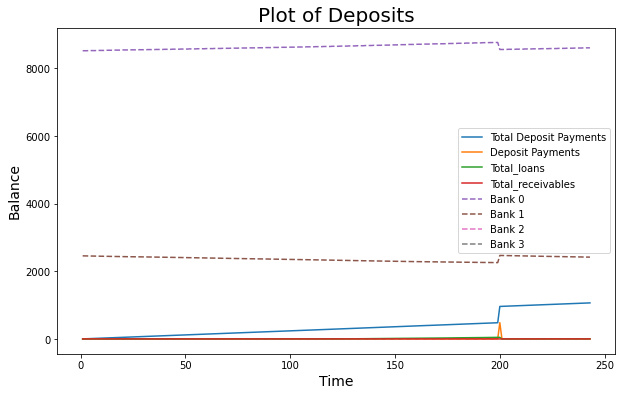

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
thesis_data.index = range(len(thesis_data))
thesis_data_plot = thesis_data[['Total Deposit Payments', 'Deposit Payments', 'Bank 0 Deposits', "Bank 1 Deposits", "Bank 2 Deposits", "Bank 3 Deposits", "Total Loans", "Total Receivables"]].drop([0])#, 'Open Market Operations']].drop([0])#.drop(["Total Output", "Bank 0 Reserves", "Bank 1 Reserves", "Bank 2 Reserves", "Bank 3 Reserves", 'Bank 0 Interbank Loans', 'Bank 1 Interbank Loans', 'Bank 2 Interbank Loans', 'Bank 3 Interbank Loans', "interbank_loans", "loans", "reserves", "bank_notes", "open_market_operations_0","ach_payee_bank_0"], 1)
ax.plot(thesis_data_plot.index, thesis_data_plot[['Total Deposit Payments', 'Deposit Payments', "Total Loans", "Total Receivables"]])
ax.plot(thesis_data_plot.index, thesis_data_plot[['Bank 0 Deposits', "Bank 1 Deposits", "Bank 2 Deposits", "Bank 3 Deposits"]], "--")
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['Total Deposit Payments', 'Deposit Payments', "Total_loans", "Total_receivables", "Bank 0 ", "Bank 1", "Bank 2", "Bank 3"])
plt.title("Plot of Deposits", size=20)

fig.savefig('figures/Deposit_Payments.png')

/var/folders/nx/sfr0g06x255301jlc_nyn7c00000gn/T/ipykernel_43547/326513055.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  thesis_data_plot = thesis_data.drop(['Total Output','Total Deposit Payments', 'Deposit Payments', 'Total Deposits', 'Total Loans', 'Total Receivables', 'Bank 0 Deposits', 'Bank 1 Deposits', 'Bank 2 Deposits', 'Bank 3 Deposits', "interbank_loans", "loans", "reserves", "bank_notes", "open_market_operations_0","ach_payee_bank_0"], 1)


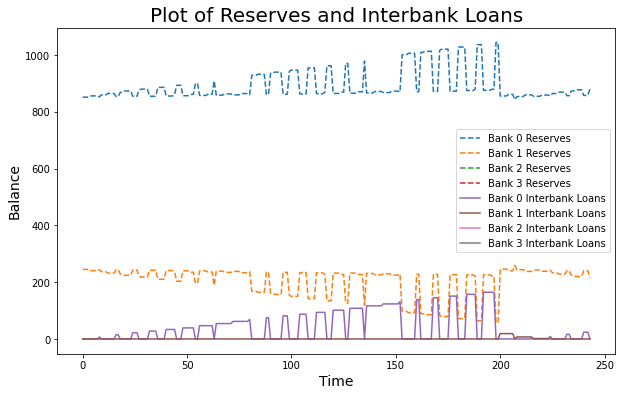

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
thesis_data.index = range(len(thesis_data))
thesis_data_plot = thesis_data.drop(['Total Output','Total Deposit Payments', 'Deposit Payments', 'Total Deposits', 'Total Loans', 'Total Receivables', 'Bank 0 Deposits', 'Bank 1 Deposits', 'Bank 2 Deposits', 'Bank 3 Deposits', "interbank_loans", "loans", "reserves", "bank_notes", "open_market_operations_0","ach_payee_bank_0"], 1)
#thesis_data_plot = thesis_data_plot.transform(lambda CBDC_Payments: CBDC_Payments * gdp_calibrate[0]["Num_Firms"]/800 + gdp_calibrate[0]["GDP"])
ax.plot(thesis_data_plot.index, thesis_data_plot[[ "Bank 0 Reserves", "Bank 1 Reserves", "Bank 2 Reserves", "Bank 3 Reserves"]], "--")
ax.plot(thesis_data_plot.index, thesis_data_plot[['Bank 0 Interbank Loans', 'Bank 1 Interbank Loans', 'Bank 2 Interbank Loans', 'Bank 3 Interbank Loans']])
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(["Bank 0 Reserves", "Bank 1 Reserves", "Bank 2 Reserves", "Bank 3 Reserves", 'Bank 0 Interbank Loans', 'Bank 1 Interbank Loans', 'Bank 2 Interbank Loans', 'Bank 3 Interbank Loans'])
plt.title("Plot of Reserves and Interbank Loans", size=20)


fig.savefig('figures/Reserves_and_Loans.png')

<AxesSubplot:>

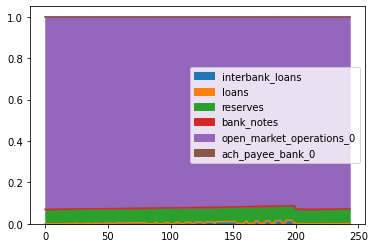

In [51]:
thesis_data_plot= thesis_data[["interbank_loans", "loans", "reserves", "bank_notes", "open_market_operations_0","ach_payee_bank_0"]]
thesis_data_plot.divide(thesis_data_plot.sum(1), 0).plot.area()

<AxesSubplot:>

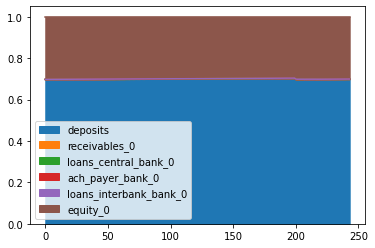

In [52]:
thesis_data_plot= thesis_data[["deposits","receivables_0","loans_central_bank_0","ach_payer_bank_0","loans_interbank_bank_0","equity_0"]]+1
thesis_data_plot.divide(thesis_data_plot.sum(1), 0).plot.area()

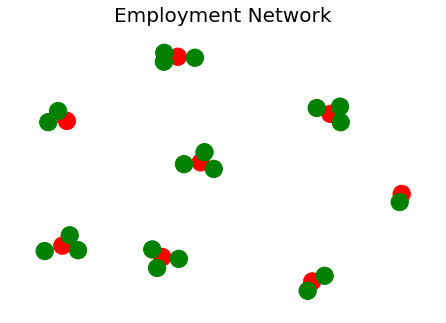

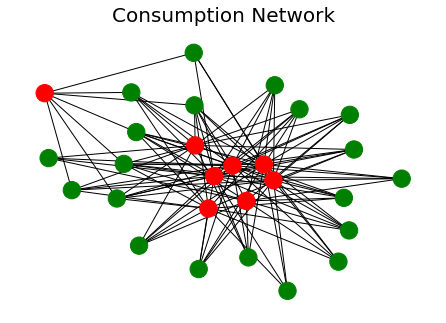

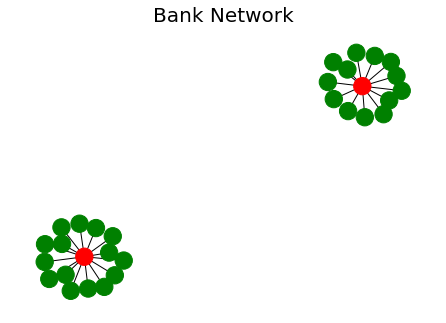

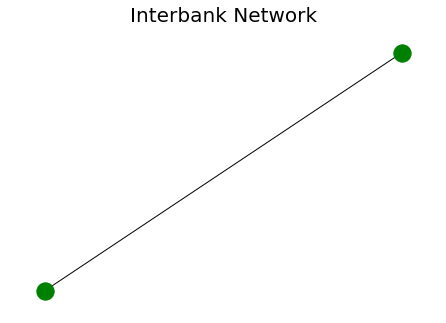

In [53]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
# Plot employment network    
E = environment.employment_network
color_map_E = ['red' if "firm" in node else 'green' for node in E]        
nx.draw(E, node_color=color_map_E)
plt.title("Employment Network", size=20)
plt.savefig('figures/employment_network.png')
plt.show()
# Plot consumption network
C = environment.consumption_network
color_map_C = ['red' if "firm" in node else 'green' for node in C]        
nx.draw(C, node_color=color_map_C)
plt.title("Consumption Network", size=20)
plt.savefig('figures/consumption_network.png')
plt.show()
# Plot bank network
B = environment.bank_network
color_map_B = ['red' if "bank" in node else 'green' for node in B]        
nx.draw(B, node_color=color_map_B)
plt.title("Bank Network", size=20)
plt.savefig('figures/bank_network.png')
plt.show()
# Plot interbank network
I = environment.interbank_network    
nx.draw(I, node_color="g")
plt.title("Interbank Network", size=20)
plt.savefig('figures/interbank_network.png')
plt.show()


In [54]:
# hh = environment.households[0]
# hh_bank_acc = environment.bank_network.adj[hh.identifier]
# firm = environment.firms[0]
# firm_bank_acc = environment.bank_network.adj[firm.identifier]
# time = 1
# k = 100
# print(hh.identifier)
# print(firm.identifier)
# consumption_demand = {"type_": "deposit", "from_" : hh.identifier, "to" : firm.identifier, "amount" : k, "bank_from":hh_bank_acc, "bank_to":firm_bank_acc, "time" : time}
# environment.new_transaction(type_="deposits", asset='', from_= consumption_demand["from_"], to = consumption_demand["to"], amount = consumption_demand["amount"], interest=0.05, maturity=0, time_of_default=-1)

In [55]:
# hh = environment.households[0]
# print(hh.accounts[-1])

# done_list = []  # This keeps the IDs of updated transactions
#     # The above is important as the same transactions may be on the books
#     # of different agents, we don't want to double count the interest
# for agent in environment.agents_generator():  # Iterate over all agents

#     for tranx in agent.accounts:  # Iterate over all transactions
#         if tranx.identifier not in done_list:  # If not amended previously
#             # The below adds the interest on the principal amount

#             tranx.amount = tranx.amount + tranx.amount * tranx.interest
#             # The below makes sure that we don't double count
#             done_list.append(tranx.identifier)

# print(hh.accounts[-1])